# Analyzing the hidden states from the search tree

In [1]:
from utils import *

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
model.eval()
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.prediction.res_blocks.register_forward_hook(get_activation('res_blocks'))

In [7]:
grid = np.array([[2, 0, 0, 2, 0],
                [2, 0, 2, 2, 2],
                [0, 2, 0, 1, 0],
                [0, 1, 1, 0, 0],
                [0, 1, 1, 1, 0],
                [1, 1, 1, 1, 1]])
player_to_move = 1
board = Board(5, grid)
state = State(board=board, player_to_move = player_to_move)
tree = Tree(model)   
p_target = tree.think(state, 400, 0.1, show=False)

In [87]:
activations = []
states = []

USE_ATTACK = True
USE_DEFENCE = True
USE_N_ALL = False

vals = []
player = []
paths = []
furthest_white = []

for path in tree.nodes.keys():
    if path != "":
        state_ = rollout(state, path)
        
        if USE_ATTACK:
            if state_.player_to_move == 1:
                states.append(state_)        
                x = state_.feature()
                output = model.prediction.inference(x)
                act = activation['res_blocks']
                activations.append(act.flatten().cpu().numpy())
                vals.append(tree.nodes[path].n_all)
                player.append(state_.player_to_move)
                paths.append(path)
                furthest_white.append(np.min(np.where(state_.board.grid == 1)[0]))
                
        if USE_DEFENCE:
            if state_.player_to_move != 1:
                states.append(state_)    
                x = state_.feature()
                output = model.prediction.inference(x)
                act = activation['res_blocks']
                activations.append(act.flatten().cpu().numpy())
                vals.append(tree.nodes[path].n_all)
                player.append(state_.player_to_move)
                paths.append(path)
                furthest_white.append(np.min(np.where(state_.board.grid == 1)[0])*-1)
                

In [102]:
print(state_)
white_pos = np.where(state_.board.grid == 1)
print(white_pos)
min_idx = np.min(white_pos[0])
print(min_idx)

6  B . . B .
5  B . . W .
4  . B . B B
3  . . W . .
2  . W W W .
1  W W W W W

   a b c d e

(array([1, 3, 4, 4, 4, 5, 5, 5, 5, 5]), array([3, 2, 1, 2, 3, 0, 1, 2, 3, 4]))
1


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 310 samples in 0.000s...
[t-SNE] Computed neighbors for 310 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 310 / 310
[t-SNE] Mean sigma: 22.554649
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.851963
[t-SNE] KL divergence after 300 iterations: 0.373527


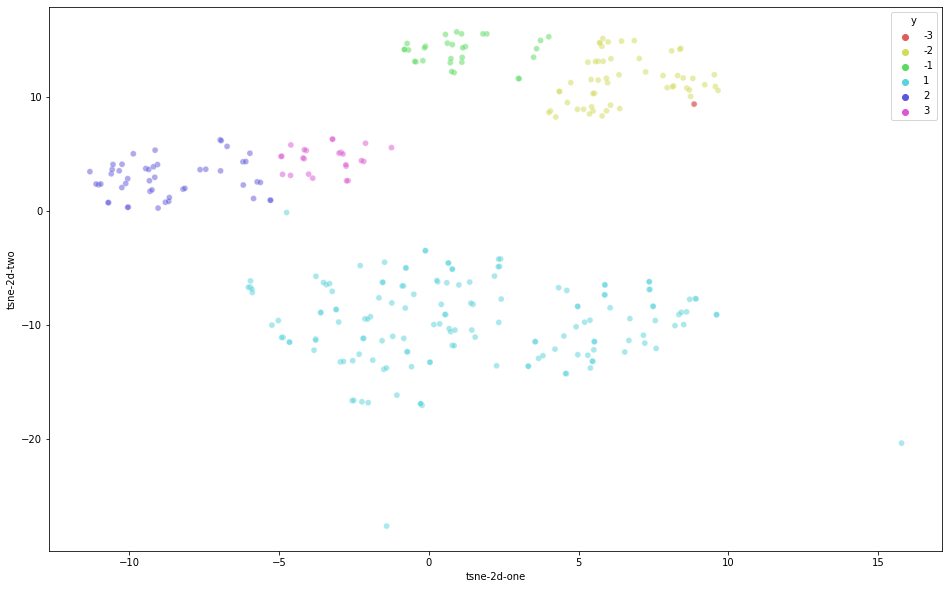

In [97]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

data = np.stack(activations)
bins = np.linspace(0, 3, 2)
digitized = np.digitize(vals, bins)

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data)

df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['y'] = furthest_white
df_subset['path'] = paths


plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", len(df_subset['y'].unique())),
    data=df_subset,
    legend="full",
    alpha=0.5
)
plt.show()

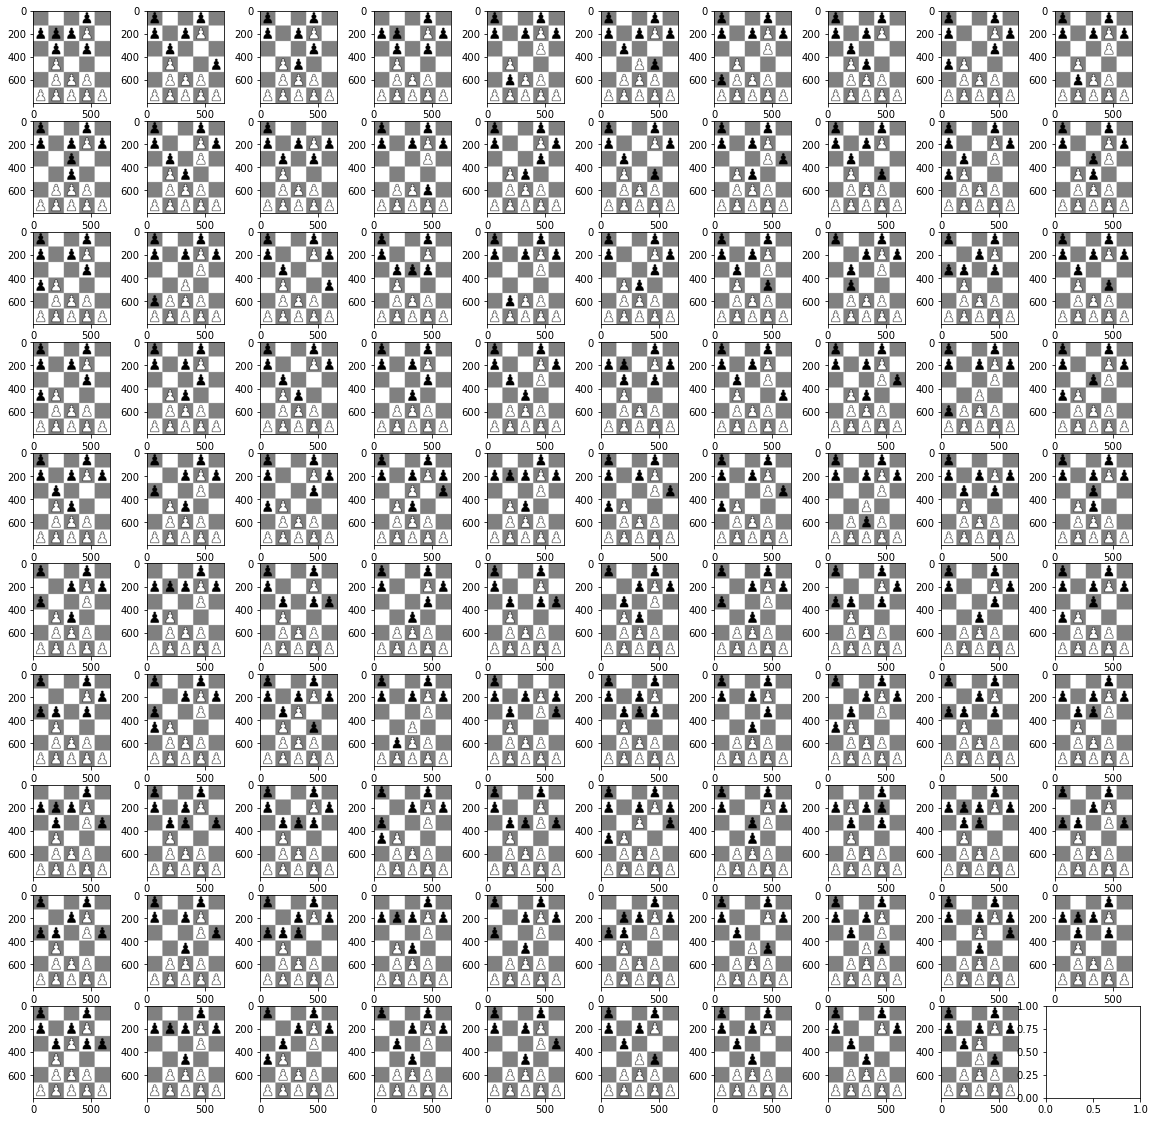

In [112]:
df_ = df_subset[(df_subset['tsne-2d-one'] < 3) & (df_subset['y'] == 1)]

grid_size = int(np.ceil(np.sqrt(len(df_))))
fig, axs = plt.subplots(grid_size, grid_size, figsize = (20,20))

for num, (idx, rows) in enumerate(df_.iterrows()):
    state_ = rollout(state, rows['path'])
    axs[num // grid_size, num % grid_size].imshow(get_image_array(state_))

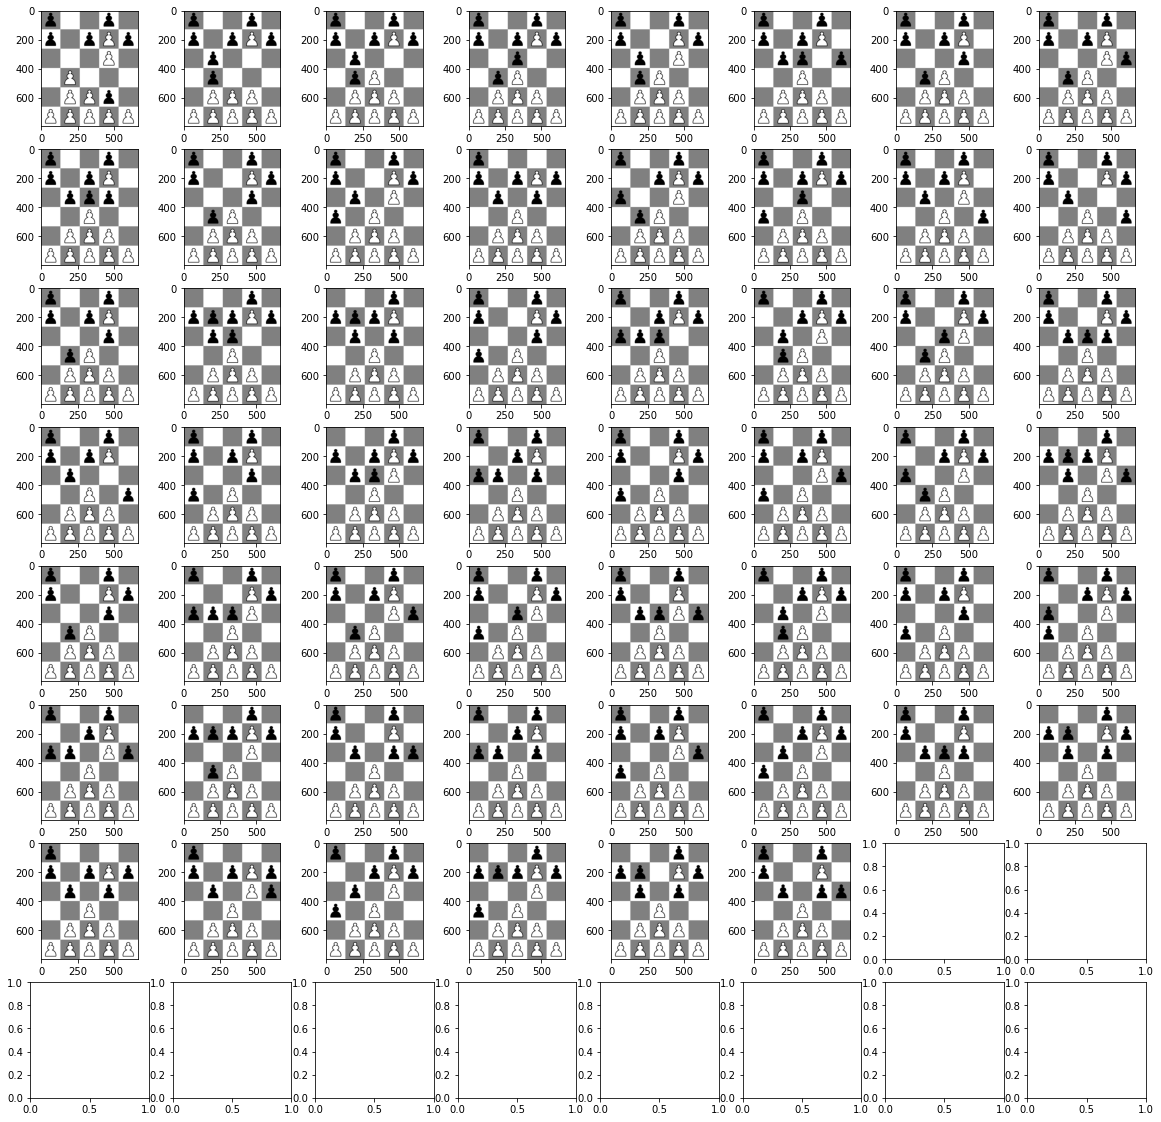

In [113]:
df_ = df_subset[(df_subset['tsne-2d-one'] > 3) & (df_subset['y'] == 1)]

grid_size = int(np.ceil(np.sqrt(len(df_))))
fig, axs = plt.subplots(grid_size, grid_size, figsize = (20,20))

for num, (idx, rows) in enumerate(df_.iterrows()):
    state_ = rollout(state, rows['path'])
    axs[num // grid_size, num % grid_size].imshow(get_image_array(state_))